In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.dummy import DummyRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from custom_transformers import LogTransformer
from sklearn.model_selection import cross_val_predict

warnings.filterwarnings("ignore", category=ConvergenceWarning)
import os
import warnings
warnings.filterwarnings('ignore')


### Preprocessing

In [21]:
os.makedirs('./output_csv', exist_ok=True)
df = pd.read_csv('../build_dataset/output_csv/bloomberg_data.csv')
df = df.dropna(subset=['Offer To 1st Close'])
df.head(3)

,Issuer Ticker,Issuer Name,Offer Size (M),Sales - 1 Yr Growth,Profit Margin,Return on Assets,Shares Outstanding (M),Offer Price,Offer To 1st Close,Market Cap at Offer (M),...,Filing Term Price Range,Priced Range,Industry Group,Industry Sector,Industry Subgroup,Instit Owner (% Shares Out),Fed Rate,CPI,Consumer Confidence,Unemployment Rate
0,AWE US,New Cingular Wireless Services Inc,10620.00,NaN,NaN,0.075987,360.0,29.5,7.838983,10620.0,...,26.00 - 32.00,Priced Within Range,Telecommunications,Communications,Cellular Telecom,0.000341,6.019667,180.3,109.2,3.8
1,3527578Q US,Agere Systems Inc,4140.00,-6.3,1.2,3.300000,600.0,6.0,0.333333,3600.0,...,6.00 - 7.00,Priced Within Range,Semiconductors,Technology,Electronic Compo-Semicon,NaN,5.310968,184.7,91.5,4.3
2,BGPTQ US,BearingPoint Inc,2328.38,-7.4,-1.0,-1.700000,0.0,18.0,30.468750,0.0,...,16.00 - 18.00,Priced Within Range,Commercial Services,"Consumer, Non-cyclical",Consulting Services,0.009101,5.494286,184.4,90.6,4.2


In [22]:
def add_rolling_ipos(df):
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df = df.sort_values('Trade Date (US)')
    df['Prev_5_IPOs_Avg_Return'] = df['Offer To 1st Close'].rolling(window=5, min_periods=1).mean().shift(1)
    df = df.reset_index(drop=True)
    
    return df

df_rolling_ipos = add_rolling_ipos(df)

In [23]:
def convert_trade_date(df):
    """
    Convert the 'Trade Date (US)' column to separate columns for 
    month, day, and year, and drop the original 'Trade Date (US)' column.
    """
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df.drop(columns=['Trade Date (US)'], inplace=True)
    return df

df_convert_trade_date = convert_trade_date(df_rolling_ipos)

In [24]:
def drop_columns(columns,df):
    """
    Drop the specified columns from the DataFrame.
    """
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker',
                                'Issuer Name',
                                'Filing Term Price Range',
                                'cusip',
                                'Priced Range'],
                                df_convert_trade_date)

In [25]:
def encoding(df):
    """
    Split the DataFrame into development and testing sets and encode the columns.
    """

    X = df.drop(columns=['Offer To 1st Close'])
    y = df['Offer To 1st Close']

    assert y.isnull().sum() == 0, "Target variable contains missing values"
    
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    # FILL MISSING VALUES
    for col in X_dev.columns:
        if col in ['Trade Month', 'Trade Day', 'Trade Year']:
            X_dev[col] = X_dev[col].fillna(X_dev[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_dev[col].mode()[0])
        elif X_dev[col].dtype == 'object':
            X_dev[col] = X_dev[col].fillna(X_dev[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_dev[col].mode()[0])
        else:
            X_dev[col] = X_dev[col].fillna(X_dev[col].mean())
            X_test[col] = X_test[col].fillna(X_test[col].mean())

    print(f"X_dev.shape before encoding: {X_dev.shape}")
    print(f"X_test.shape before encoding: {X_test.shape}")

    # ENCODING FEATURES
    oe_columns = ['Trade Month', 'Trade Day', 'Trade Year']
    ohe_columns = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    log_columns = ['Offer Price', 'Market Cap at Offer (M)']
    exclude_columns = oe_columns + log_columns + ohe_columns
    ss_columns = [col for col in X.select_dtypes(exclude=['object']).columns if col not in exclude_columns]

    print(f"\nss_columns: {len(ss_columns)}")
    print(f"oe_columns: {len(oe_columns)}")
    print(f"ohe_columns: {len(ohe_columns)}")
    print(f"log_columns: {len(log_columns)}")

    oe = OrdinalEncoder()
    log = LogTransformer()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ss = StandardScaler()

    preprocess = ColumnTransformer(transformers=[
        ('ohe', ohe, ohe_columns),
        ('log', log, log_columns),
        ('ss', ss, ss_columns),
        ('oe', oe, oe_columns)
    ], remainder='passthrough')

    transformed_dev = preprocess.fit_transform(X_dev)
    transformed_test = preprocess.transform(X_test)

    features = preprocess.get_feature_names_out()

    df_dev = pd.DataFrame(transformed_dev, columns=features).reset_index(drop=True)
    df_test = pd.DataFrame(transformed_test, columns=features).reset_index(drop=True)

    print(f"\nX_dev.shape after encoding: {df_dev.shape}")
    print(f"X_test.shape after encoding: {df_test.shape}")

    y_dev = y_dev.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    df_dev = pd.concat([df_dev, y_dev], axis=1)
    df_test = pd.concat([df_test, y_test], axis=1)

    return df_dev, df_test, preprocess


df_dev_encoded, df_test_encoded, preprocess = encoding(df_drop_columns)


X_dev.shape before encoding: (3520, 21)
X_test.shape before encoding: (881, 21)

ss_columns: 13
oe_columns: 3
ohe_columns: 3
log_columns: 2

X_dev.shape after encoding: (3520, 409)
X_test.shape after encoding: (881, 409)


In [26]:
def show_feature_importance(df):
    """
    Calculate feature importance using a simple model
    """
    X_dev = df.drop(columns=['Offer To 1st Close'])
    y_dev = pd.DataFrame(df['Offer To 1st Close'])
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_dev, y_dev)
    importances = pd.Series(rf.feature_importances_, index=X_dev.columns)
    print("\nFeature Importances:")
    print(importances.sort_values(ascending=False).head(10))

show_feature_importance(df_dev_encoded)



Feature Importances:
log__Offer Price                0.169902
log__Market Cap at Offer (M)    0.100832
ss__Offer Size (M)              0.056995
ss__Prev_5_IPOs_Avg_Return      0.044548
ss__Return on Assets            0.040573
ss__Sales - 1 Yr Growth         0.040525
ss__Shares Outstanding (M)      0.040465
ss__Profit Margin               0.034859
ss__Fed Rate                    0.034282
ss__Cash Flow per Share         0.034038
dtype: float64


In [27]:
def get_correlation(df_dev, df_test):
    """
    Check correlation in the X_dev column and drop highly correlated features.
    """
    X_dev = df_dev.drop(columns=['Offer To 1st Close'])
    y_dev = df_dev['Offer To 1st Close']

    X_test = df_test.drop(columns=['Offer To 1st Close'])
    y_test = df_test['Offer To 1st Close']

    corr_matrix = X_dev.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

    X_reduced_dev = X_dev.drop(columns=to_drop)
    X_reduced_test = X_test.drop(columns=to_drop)

    df_dev = pd.concat([X_reduced_dev, y_dev.reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_reduced_test, y_test.reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")

    df_dev.to_csv('./output_csv/Final_Output_Reg_dev.csv', index=False)
    df_test.to_csv('./output_csv/Final_Output_Reg_test.csv', index=False)

    return df_dev, df_test

df_dev_correlation, df_test_correlation = get_correlation(df_dev_encoded, df_test_encoded)



Removed 30 correlated features.


In [28]:
def remove_outlier(df, df_type, lower_bound, upper_bound):
    """
    Remove outliers using IQR on target variable.
    """
    if isinstance(lower_bound, pd.Series):
        lower_bound = lower_bound.iloc[0]  
    if isinstance(upper_bound, pd.Series):
        upper_bound = upper_bound.iloc[0] 
        
    df_filtered = df[(df['Offer To 1st Close'] >= lower_bound) & (df['Offer To 1st Close'] <= upper_bound)]
    
    print(f"\nRemoved outliers from {df_type}.")
    print(f"Original shape: {df.shape}")
    print(f"Filtered shape: {df_filtered.shape}")
    print(f"Removed {df.shape[0] - df_filtered.shape[0]} rows")
    
    return df_filtered

In [29]:
def checkoutliers(df_dev, df_test):
    """
    Print distribution of the target variable and check for outliers.
    """
    label = df_dev['Offer To 1st Close']

    df_stat = pd.DataFrame([{
        'Minimum': label.min(),
        'Q1': label.quantile(0.25),
        'Median': label.median(),
        'Q3': label.quantile(0.75),
        'Maximum': label.max(),
        'Mean': label.mean(),
        'IQR': label.quantile(0.75) - label.quantile(0.25),
        'Standard deviation': label.std()
    }])

    display(df_stat.transpose().rename(columns={0: 'Values'}))
    print('\nChecking for outliers...')

    df_dev = remove_outlier(df_dev, 'dev', df_stat['Q1'] - 1.5 * df_stat['IQR'], df_stat['Q3'] + 1.5 * df_stat['IQR'])
    df_test = remove_outlier(df_test, 'test', df_stat['Q1'] - 1.5 * df_stat['IQR'], df_stat['Q3'] + 1.5 * df_stat['IQR'])

    df_dev.to_csv('./output_csv/Final_Output_Reg_dev.csv', index=False)
    df_test.to_csv('./output_csv/Final_Output_Reg_test.csv', index=False)


    return df_dev, df_test

df_dev_filtered, df_test_filtered = checkoutliers(df_dev_correlation, df_test_correlation)

,Values
Minimum,-27.554216
Q1,0.000000
Median,0.591667
Q3,7.500000
Maximum,130.000000
Mean,4.758685
IQR,7.500000
Standard deviation,10.263621



Checking for outliers...

Removed outliers from dev.
Original shape: (3520, 380)
Filtered shape: (3152, 380)
Removed 368 rows

Removed outliers from test.
Original shape: (881, 380)
Filtered shape: (787, 380)
Removed 94 rows


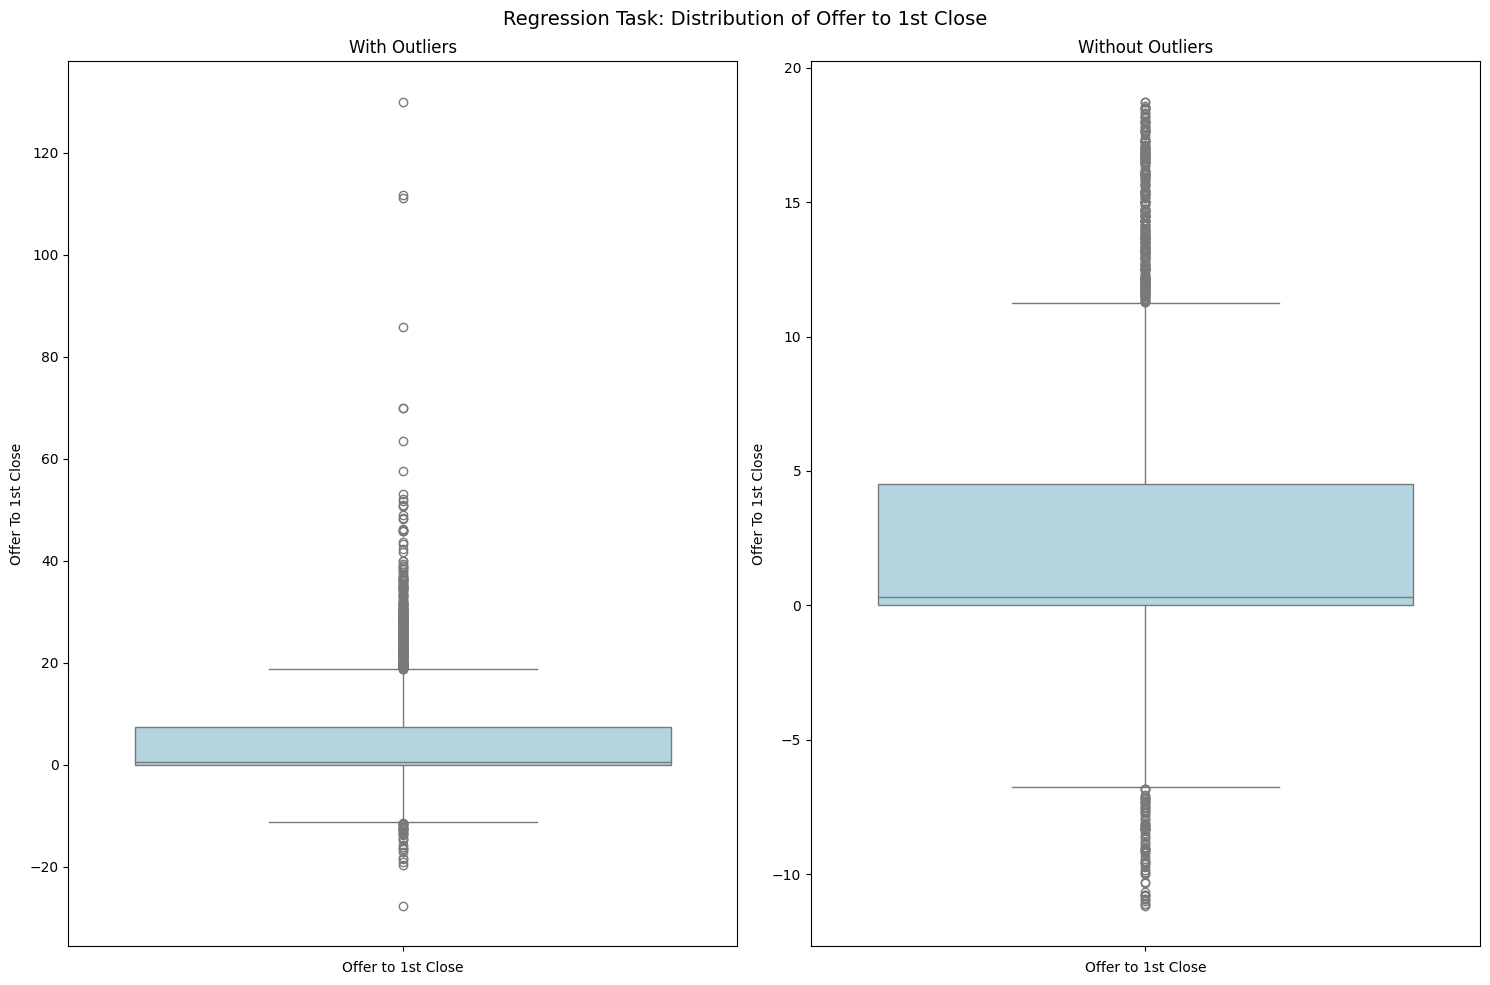

In [30]:
def display_distribution(df_no_outliers, df_with_outliers):
    """
    Display distribution of target variable before and after removing outliers.
    """
    df_no_outliers = df_no_outliers.copy()
    df_with_outliers = df_with_outliers.copy()

    fig, axs = plt.subplots(ncols=2, figsize=(15, 10))

    sns.boxplot(data=df_with_outliers, y='Offer To 1st Close', color='lightblue', ax=axs[0])
    axs[0].set_title('With Outliers')
    axs[0].set_xlabel('Offer to 1st Close')

    sns.boxplot(data=df_no_outliers, y='Offer To 1st Close', color='lightblue', ax=axs[1])
    axs[1].set_title('Without Outliers')
    axs[1].set_xlabel('Offer to 1st Close')

    fig.suptitle('Regression Task: Distribution of Offer to 1st Close', fontsize=14)
    plt.tight_layout()
    plt.show()

display_distribution(df_dev_filtered, df_dev_correlation)

### Dimensionality Reduction

In [ ]:
def apply_dimensionality_reduction(df_dev, df_test, n_components=0.95):
    """
    Apply dimensionality reduction techniques to the data.
    """
    X_dev = df_dev.drop(columns=['Offer To 1st Close'])
    y_dev = df_dev['Offer To 1st Close']
    
    X_test = df_test.drop(columns=['Offer To 1st Close'])
    y_test = df_test['Offer To 1st Close']

    pca = PCA(n_components=n_components, random_state=42)
    X_dev_pca = pca.fit_transform(X_dev)
    X_test_pca = pca.transform(X_test)

    print(f"\nNumber of components before PCA: {len(X_dev.columns)}")
    print(f"Number of components after PCA: {pca.n_components_}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()
    
    df_dev_reduced = pd.DataFrame(X_dev_pca, columns=[f'PC{i+1}' for i in range(X_dev_pca.shape[1])])
    df_test_reduced = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
    
    df_dev_reduced['Offer To 1st Close'] = y_dev.reset_index(drop=True)
    df_test_reduced['Offer To 1st Close'] = y_test.reset_index(drop=True)
    
    df_dev_reduced.to_csv('./output_csv/Final_Output_Reg_dev.csv', index=False)
    df_test_reduced.to_csv('./output_csv/Final_Output_Reg_test.csv', index=False)
    
    return df_dev_reduced, df_test_reduced


df_dev_reduced, df_test_reduced = apply_dimensionality_reduction(df_dev_filtered, df_test_filtered)  

### Model Training

In [13]:
def get_enhanced_model_params():
    """Return enhanced model parameters with wider search space"""
    return {
        "Dummy Regressor": {
            "model": DummyRegressor(strategy='mean'),
            "params": {}
        },
        "Linear Regression": {
            "model": LinearRegression(n_jobs=-1),
            "params": {}
        },
        "Ridge Regression": {
            "model": Ridge(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }
        },
        "Lasso Regression": {
            "model": Lasso(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
            }
        },
        "ElasticNet Regression": {
            "model": ElasticNet(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
                "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
            }
        },
        "LightGBM": {
            "model": LGBMRegressor(
                random_state=42,
                force_col_wise=True,  
                min_data_in_leaf=10,  
                feature_fraction=0.8,  
                bagging_fraction=0.8, 
                bagging_freq=1,     
                verbose=-1         
            ),
            "params": {
                "n_estimators": [100, 200],
                "max_depth": [5, 7],
                "learning_rate": [0.01, 0.05],
                "num_leaves": [20, 31],
                "reg_alpha": [0.01, 0.1],     
                "reg_lambda": [0.01, 0.1]
            }
        },
        "Random Forest (Light)": {
            "model": RandomForestRegressor(random_state=42, n_jobs=-1),
            "params": {
                "n_estimators": [50, 100],
                "max_depth": [3, 5],
                "min_samples_split": [5, 10]
            }
        },
        "Gradient Boosting": {
            "model": GradientBoostingRegressor(random_state=42),
            "params": {
                "n_estimators": [50, 100],
                "max_depth": [3, 5],
                "learning_rate": [0.01, 0.05],
                "subsample": [0.8, 1.0],
                "min_samples_split": [5, 10]
            }
        },
        "Extra Trees": {
            "model": ExtraTreesRegressor(random_state=42, n_jobs=-1),
            "params": {
                "n_estimators": [50, 100],
                "max_depth": [3, 5],
                "min_samples_split": [5, 10]
            }
        },
        "Kernel Ridge": {
            "model": KernelRidge(kernel='rbf'),
            "params": {
                "alpha": [0.001, 0.01, 0.1, 1.0],
                "gamma": [0.001, 0.01, 0.1, 1.0]
            }
        },
        "Neural Network": {
            "model": MLPRegressor(
                random_state=42,
                max_iter=2000,          
                early_stopping=True,    
                validation_fraction=0.1, 
                n_iter_no_change=50,    
                batch_size='auto',      
                learning_rate='adaptive' 
            ),
            "params": {
                "hidden_layer_sizes": [(100,), (100, 50), (50, 25)],
                "learning_rate_init": [0.001, 0.005],
                "alpha": [0.0001, 0.001, 0.01],
                "activation": ['relu', 'tanh'],
            }
        }
    }

In [14]:
def evaluate_models(model_params, X_dev, y_dev):
    """Evaluate models with RMSE as the primary metric"""
    results = []

    total_models = len(model_params)
    print(f"Evaluating {total_models} models...\n")

    for i, (name, mp) in enumerate(model_params.items(), 1):
        print(f"[{i}/{total_models}] Training and evaluating: {name}...", end=" ")

        try:
            if mp["params"]:
                grid = GridSearchCV(
                    mp["model"],
                    mp["params"],
                    cv=5,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1,
                    verbose=0
                )
                grid.fit(X_dev, y_dev)
                best_model = grid.best_estimator_
                print("✓ (GridSearch complete)")
                print(f"\nBest params:")
                for param, value in grid.best_params_.items():
                    print(f"   - {param}: {value}")
            else:
                best_model = mp["model"]
                best_model.fit(X_dev, y_dev)
                print("✓ (No tuning needed)")

            scoring = {
                'r2': 'r2',
                'rmse': 'neg_root_mean_squared_error',
                'mae': 'neg_mean_absolute_error',
                'mse': 'neg_mean_squared_error'
            }

            cv_results = cross_validate(
                best_model,
                X_dev,
                y_dev,
                cv=5,
                scoring=scoring,
                return_train_score=False,
                n_jobs=-1,
                verbose=0
            )

            results.append({
                "Model": name,
                "R²": cv_results['test_r2'].mean(),
                "RMSE": -cv_results['test_rmse'].mean(),
                "MAE": -cv_results['test_mae'].mean(),
                "MSE": -cv_results['test_mse'].mean()
            })
            
            train_sizes, train_scores, val_scores = learning_curve(
                best_model, X_dev, y_dev, cv=5,
                scoring='neg_root_mean_squared_error',
                train_sizes=np.linspace(0.1, 1.0, 10)
            )

            train_scores = -train_scores
            val_scores = -val_scores

            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, train_scores.mean(axis=1), label='Training RMSE')
            plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation RMSE')
            plt.fill_between(train_sizes,
                           train_scores.mean(axis=1) - train_scores.std(axis=1),
                           train_scores.mean(axis=1) + train_scores.std(axis=1),
                           alpha=0.1)
            plt.fill_between(train_sizes,
                           val_scores.mean(axis=1) - val_scores.std(axis=1),
                           val_scores.mean(axis=1) + val_scores.std(axis=1),
                           alpha=0.1)
            plt.title(f'Learning Curves - {name}')
            plt.xlabel('Training examples')
            plt.ylabel('Root Mean Squared Error')
            plt.legend()
            plt.grid(True)
            plt.show()

            y_pred_cv = cross_val_predict(best_model, X_dev, y_dev, cv=5, n_jobs=-1)
            
            assert len(y_pred_cv) == len(y_dev), "y_pred_cv and y_dev have different lengths"

            residuals = y_dev - y_pred_cv
            plt.figure(figsize=(10, 6))
            plt.scatter(y_pred_cv, residuals, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.title(f'Residual Plot - {name}')
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.scatter(y_dev, y_pred_cv, alpha=0.5)
            plt.plot([y_dev.min(), y_dev.max()], 
                    [y_dev.min(), y_dev.max()], 
                    'r--', lw=2)
            plt.title(f'Actual vs Predicted - {name}')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.grid(True)
            plt.show()


        except Exception as e:
            print(f"✗ Error with {name}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)

    top5_models_df = results_df.sort_values(by="RMSE", ascending=True).head(5).reset_index(drop=True)

    return results_df, top5_models_df

In [15]:
def evaluate_best_model(model_params, X_dev, y_dev, X_test, y_test, top5_models_df):
    """
    Evaluate the best model on the test set
    """

    best_model_name = top5_models_df.iloc[0]['Model']
    best_model = model_params[best_model_name]['model']
    best_model.fit(X_dev, y_dev)

    dummy_model = model_params['Dummy Regressor']['model']
    dummy_model.fit(X_dev, y_dev)

    y_pred = best_model.predict(X_test)
    y_pred_dummy = dummy_model.predict(X_test)

    print(f"Best model: {best_model_name}")
    print("Best model params: ")
    for param, value in best_model.get_params().items():
        print(f"   - {param}: {value}")

    test_metrics = {
        "Model": best_model_name,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
    }

    test_metrics_dummy = {
        "Model": "Dummy Regressor",
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_dummy)),
        "MAE": mean_absolute_error(y_test, y_pred_dummy),
        "R² Score": r2_score(y_test, y_pred_dummy)
    }

    metrics_df = pd.DataFrame([test_metrics])
    metrics_df.to_csv('./output_csv/best_model_Reg_test_results.csv', index=False)

    metrics_df_dummy = pd.DataFrame([test_metrics_dummy])

    print("\nBest Model Test Set Performance:")
    display(metrics_df)

    print("\nDummy Model Test Set Performance:")
    display(metrics_df_dummy)



In [16]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r"[^\w\d_]+", "_", regex=True)
    return df

In [17]:
def main():
    try:
        df_dev = pd.read_csv('./output_csv/Final_Output_Reg_dev.csv')
        df_test = pd.read_csv('./output_csv/Final_Output_Reg_test.csv')

        X_dev = clean_column_names(df_dev.drop(columns=['Offer To 1st Close']))
        y_dev = df_dev['Offer To 1st Close']

        X_test = clean_column_names(df_test.drop(columns=['Offer To 1st Close']))
        y_test = df_test['Offer To 1st Close']

        model_params = get_enhanced_model_params()
        results_df, top5_models_df = evaluate_models(model_params, X_dev, y_dev)

        print("\nTop 5 Models:")
        display(top5_models_df)

        results_df.to_csv('./output_csv/regression_results.csv', index=False)
        top5_models_df.to_csv('./output_csv/top5_regression_models.csv', index=False)

        evaluate_best_model(model_params, X_dev, y_dev, X_test, y_test, top5_models_df)

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise


Evaluating 11 models...

[1/11] Training and evaluating: Dummy Regressor... ✓ (No tuning needed)


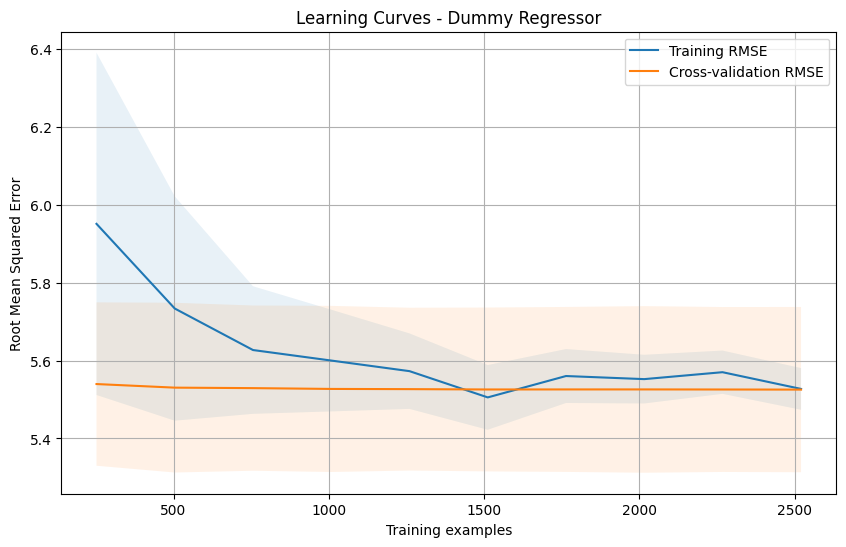

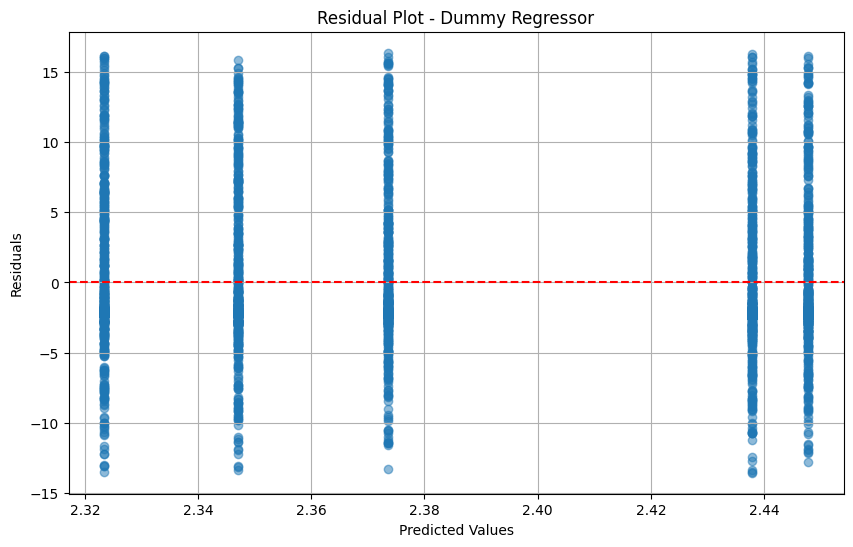

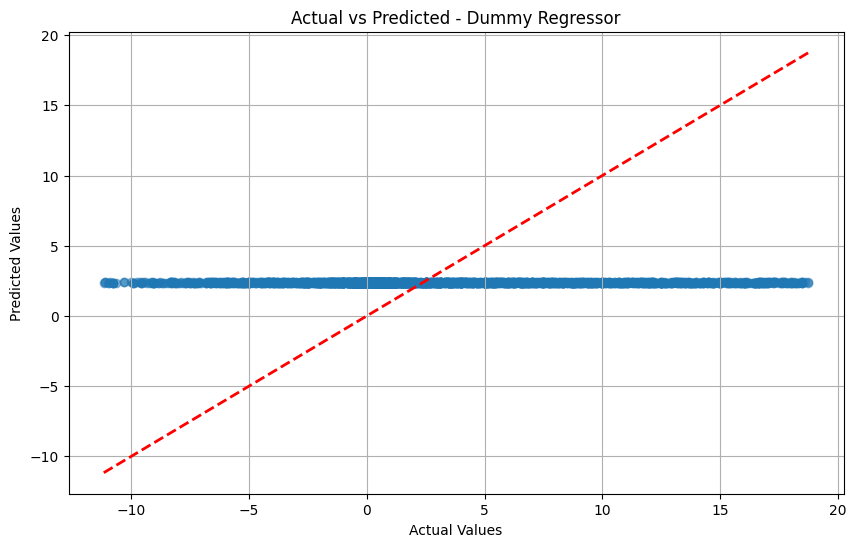

[2/11] Training and evaluating: Linear Regression... ✓ (No tuning needed)


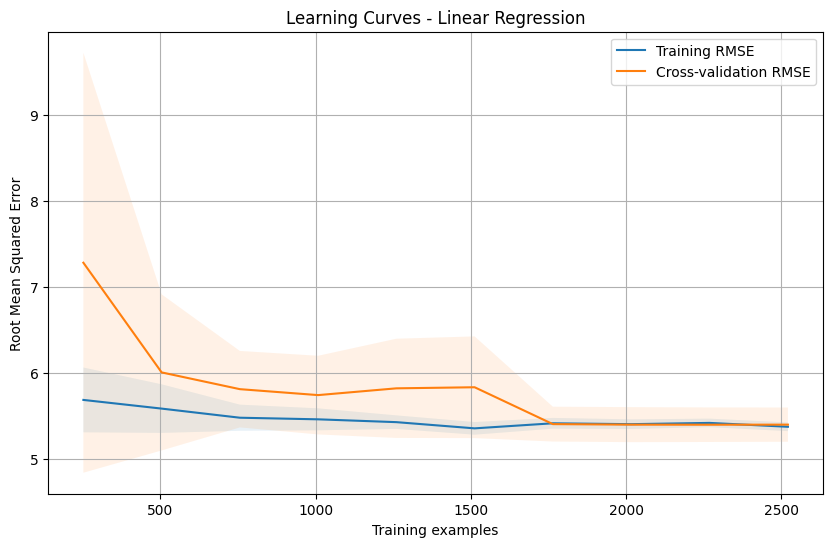

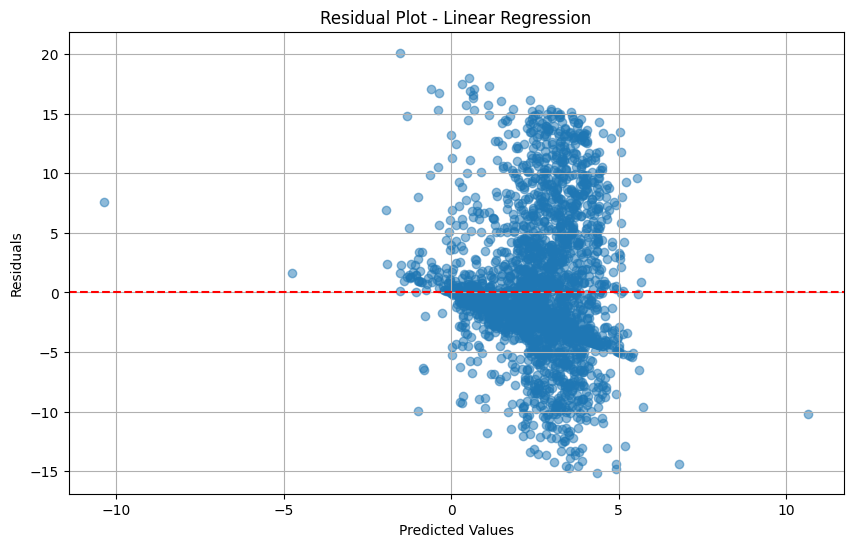

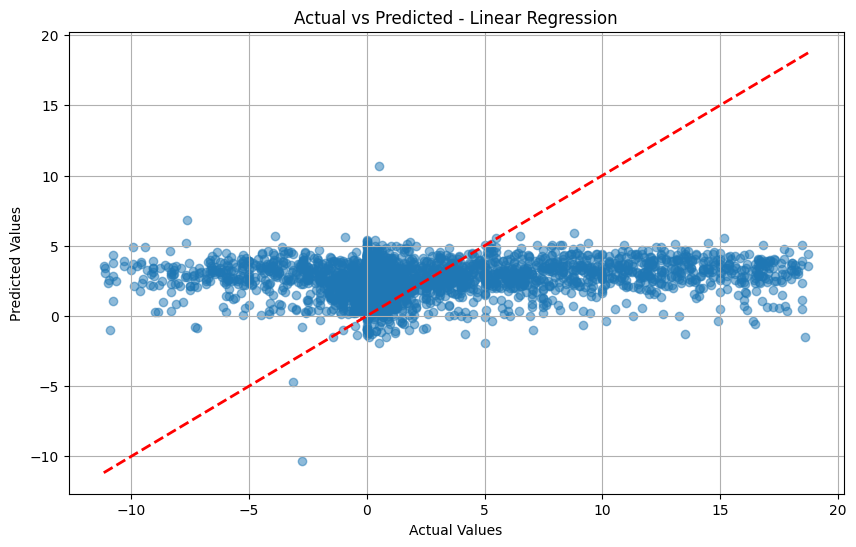

[3/11] Training and evaluating: Ridge Regression... ✓ (GridSearch complete)

Best params:
   - alpha: 1000


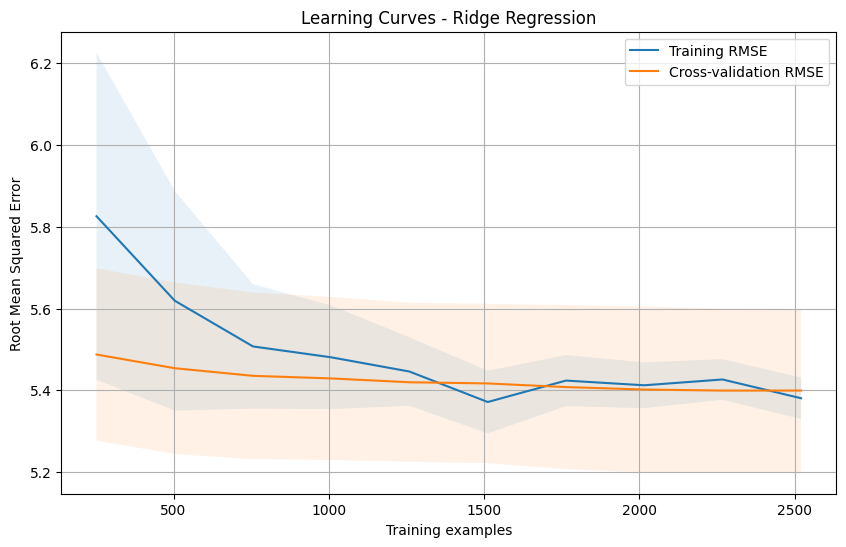

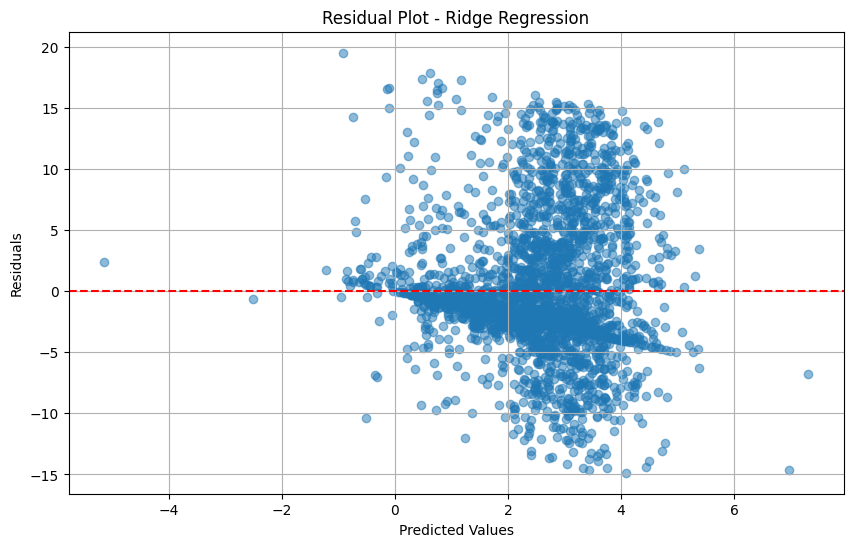

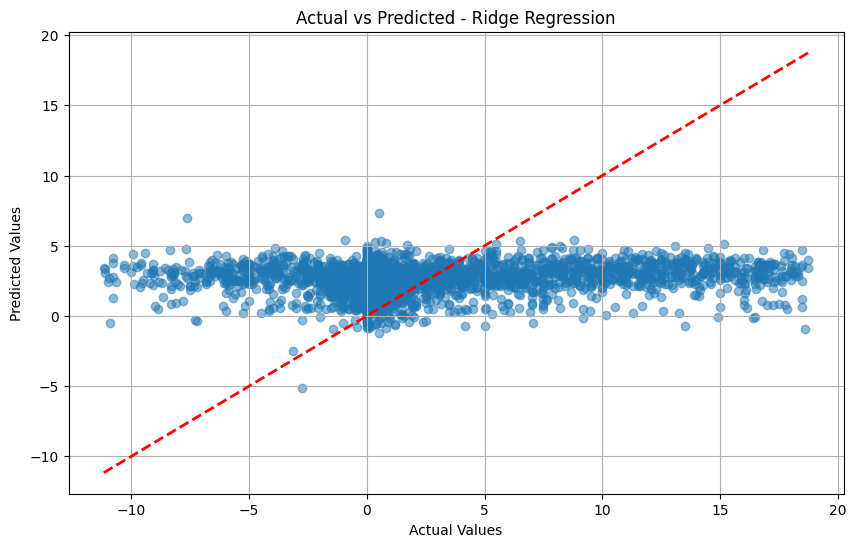

[4/11] Training and evaluating: Lasso Regression... ✓ (GridSearch complete)

Best params:
   - alpha: 0.1


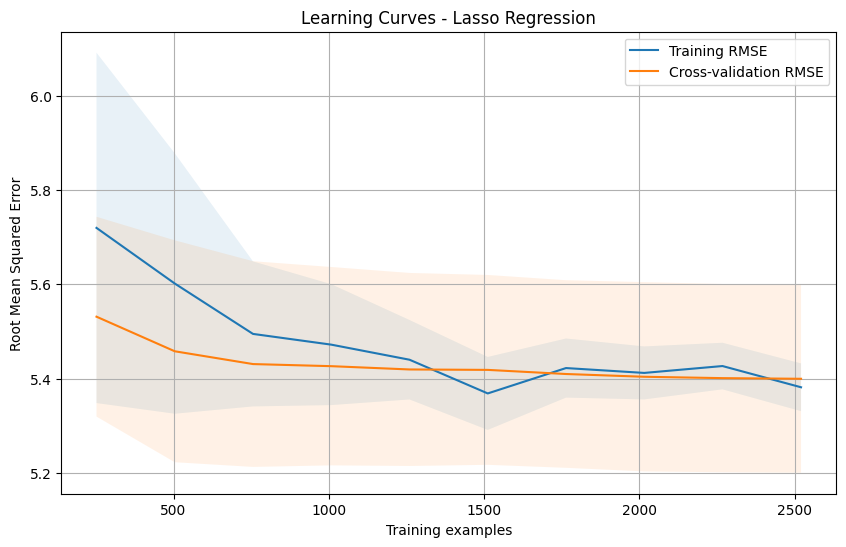

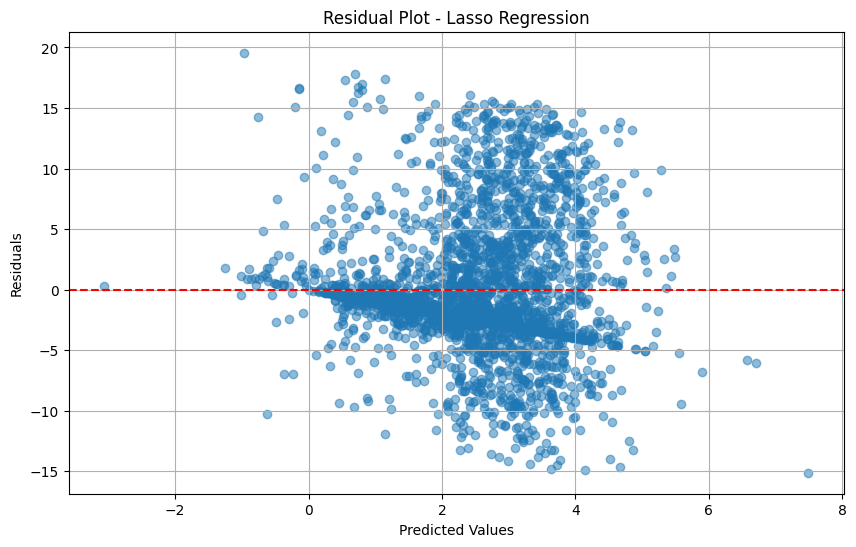

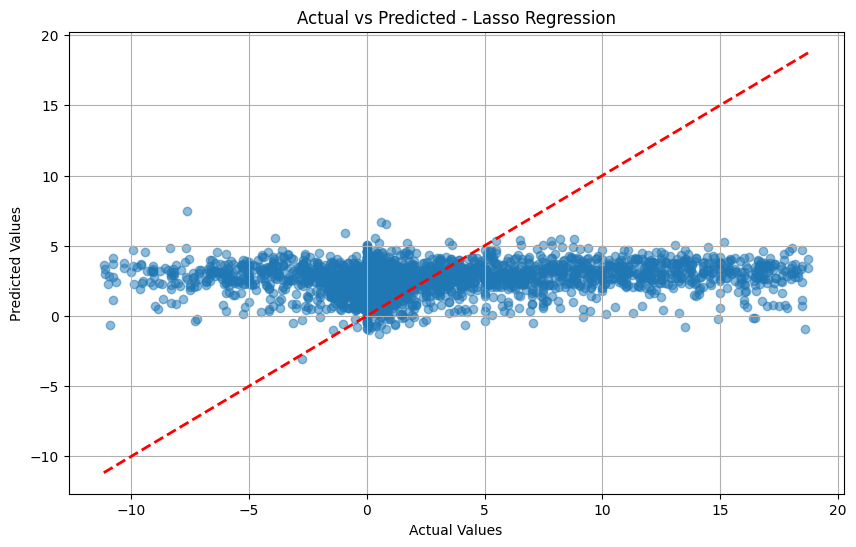

[5/11] Training and evaluating: ElasticNet Regression... ✓ (GridSearch complete)

Best params:
   - alpha: 0.1
   - l1_ratio: 0.5


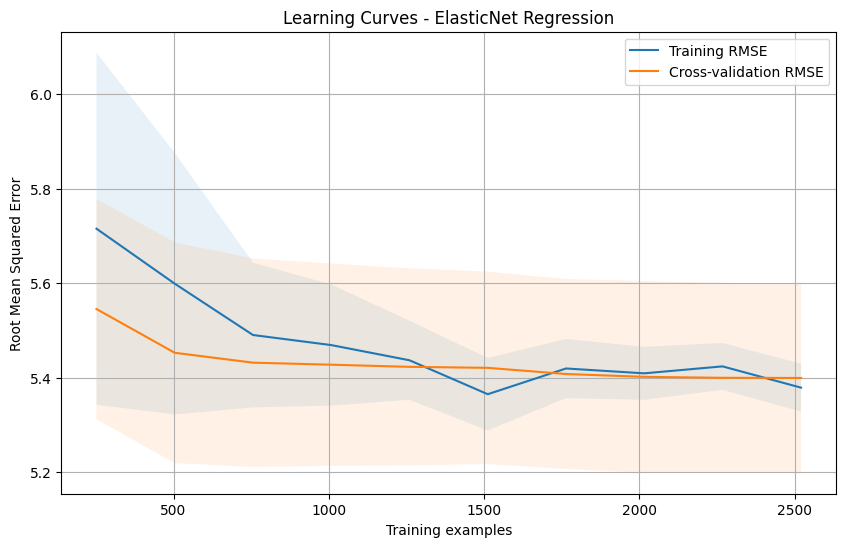

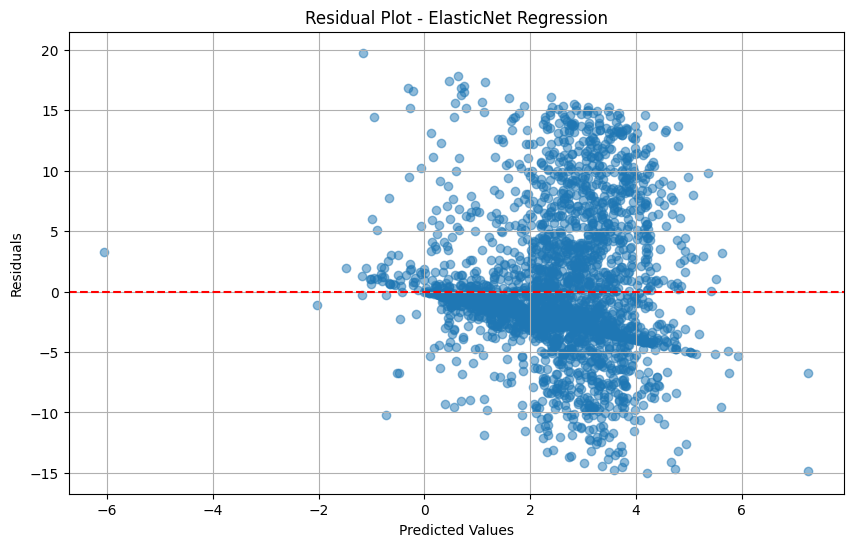

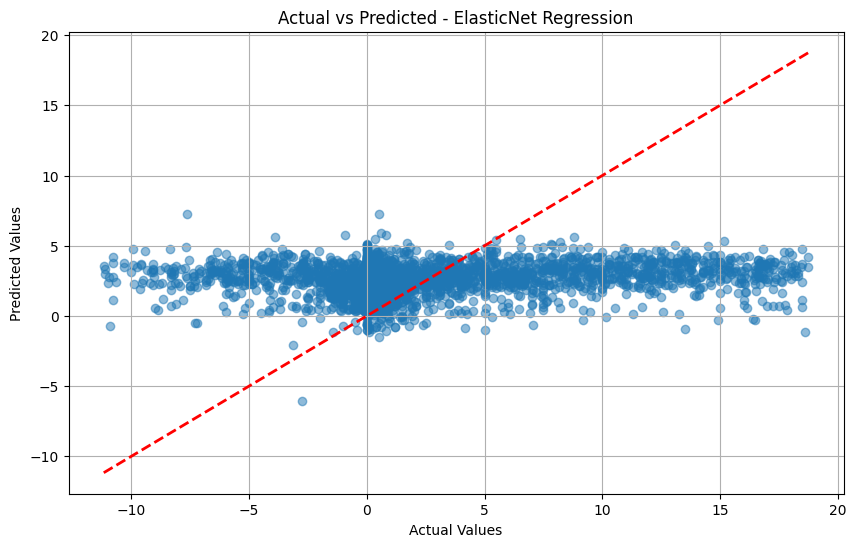

[6/11] Training and evaluating: LightGBM... ✓ (GridSearch complete)

Best params:
   - learning_rate: 0.01
   - max_depth: 5
   - n_estimators: 200
   - num_leaves: 20
   - reg_alpha: 0.1
   - reg_lambda: 0.01


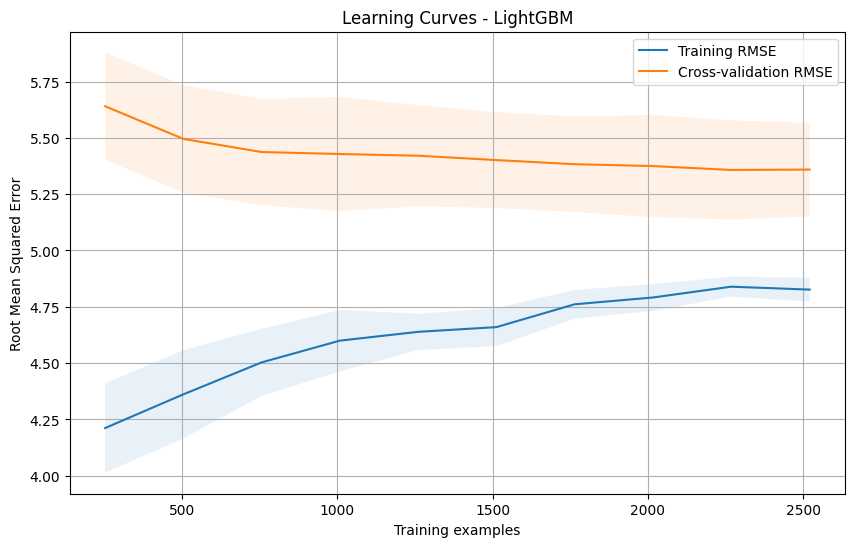

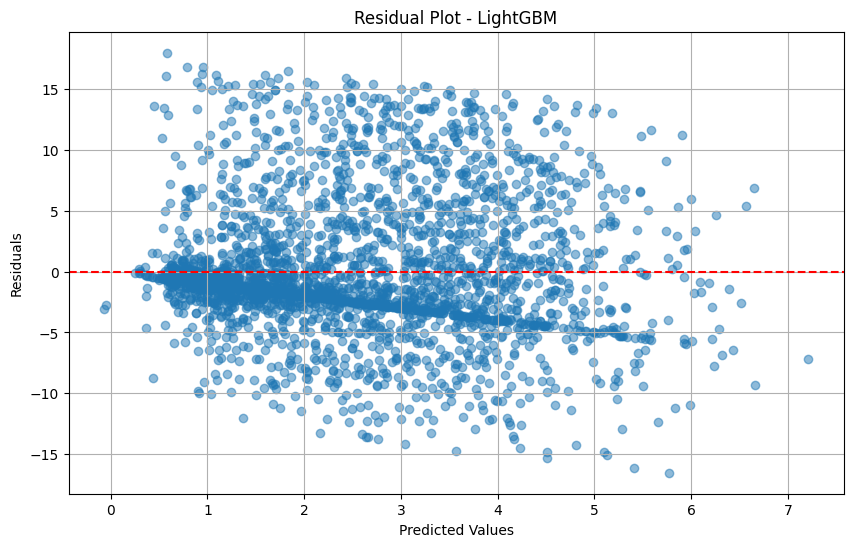

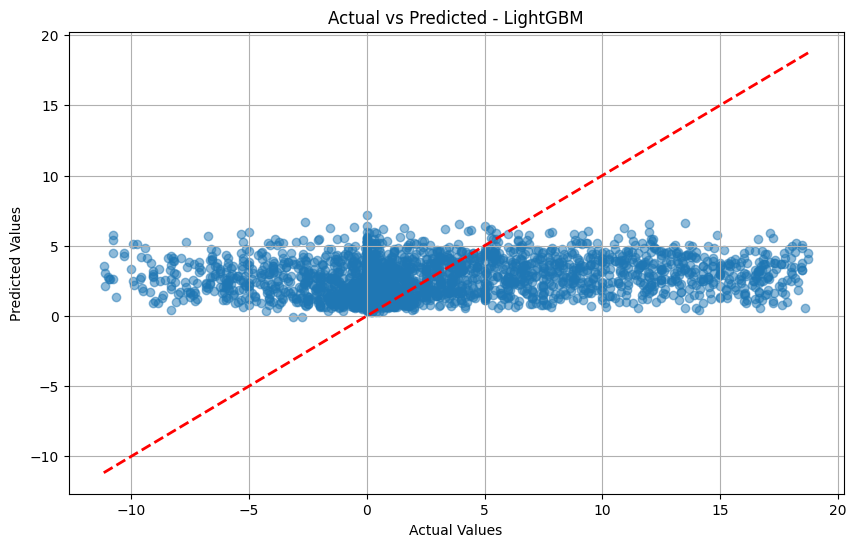

[7/11] Training and evaluating: Random Forest (Light)... ✓ (GridSearch complete)

Best params:
   - max_depth: 5
   - min_samples_split: 5
   - n_estimators: 50


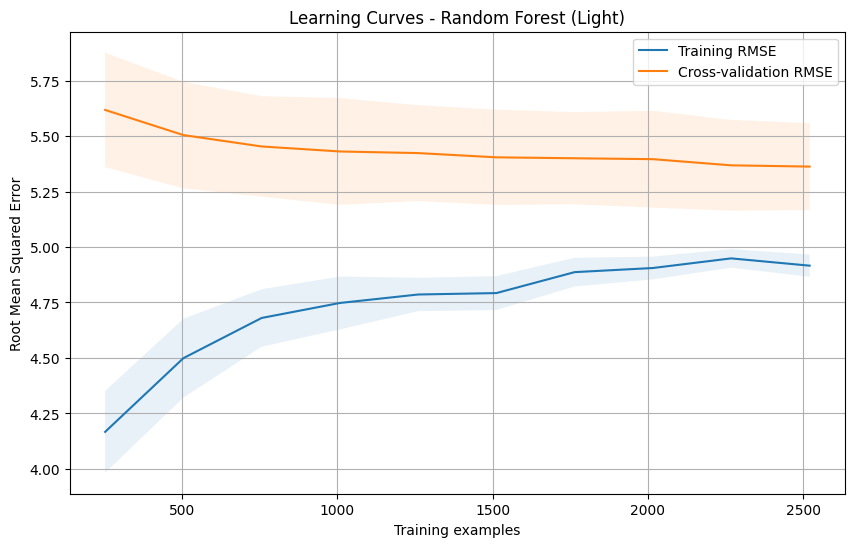

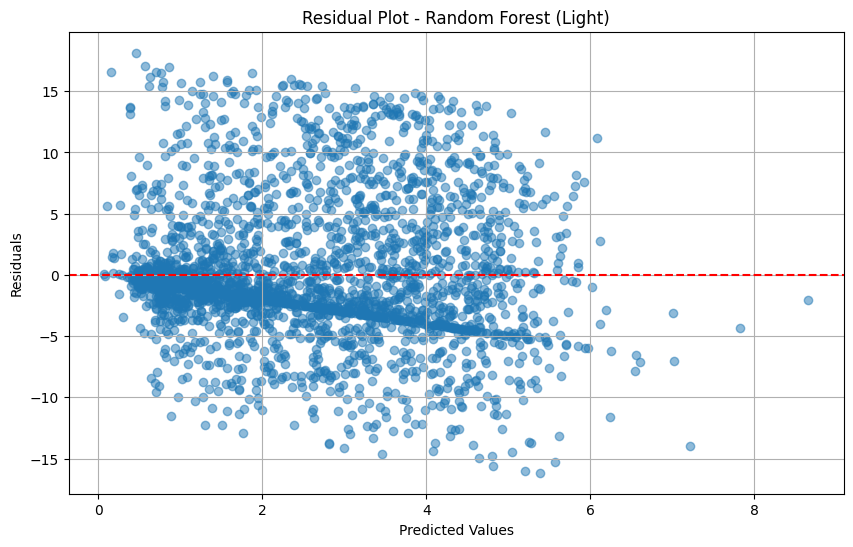

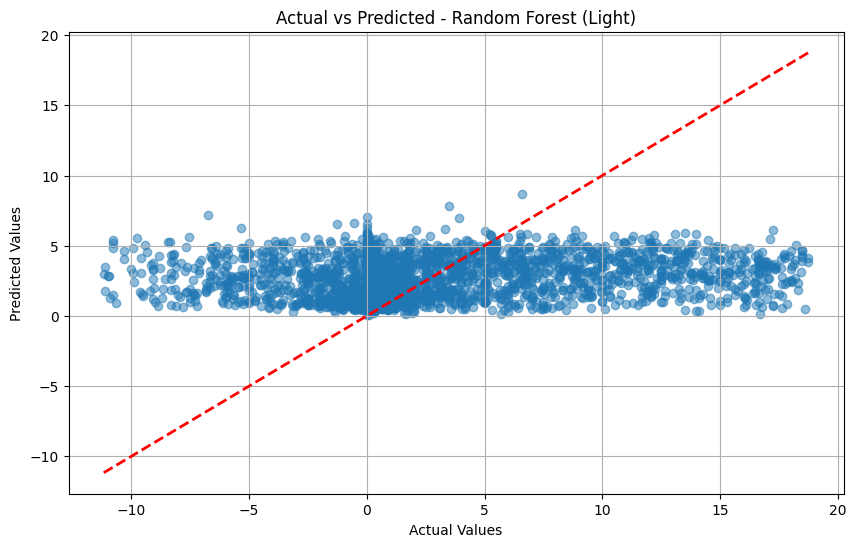

[8/11] Training and evaluating: Gradient Boosting... ✓ (GridSearch complete)

Best params:
   - learning_rate: 0.05
   - max_depth: 3
   - min_samples_split: 5
   - n_estimators: 50
   - subsample: 0.8


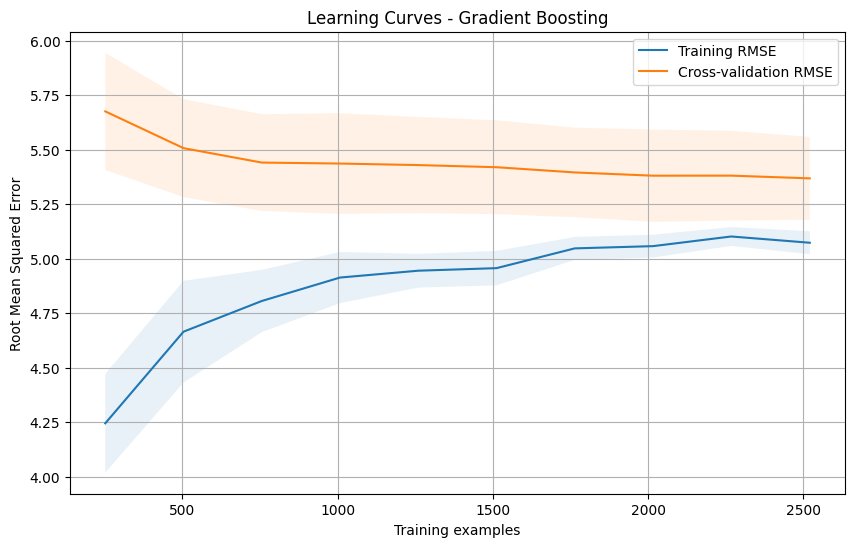

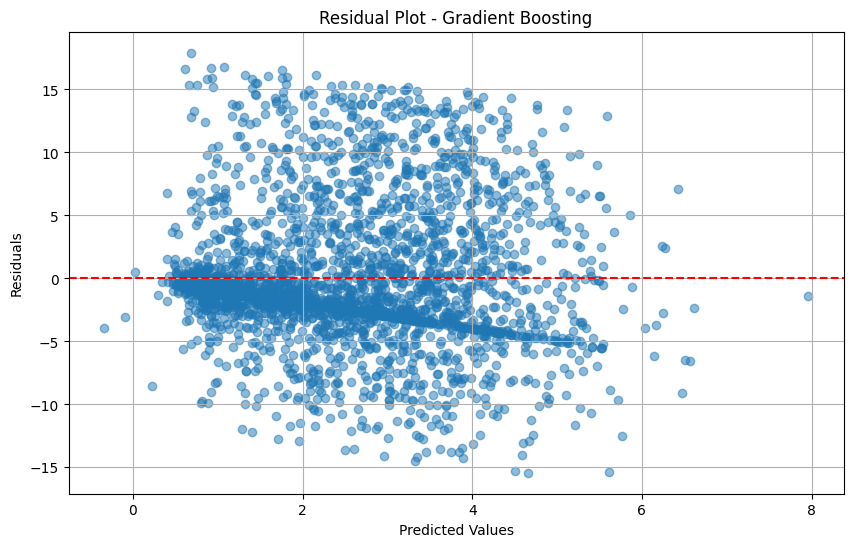

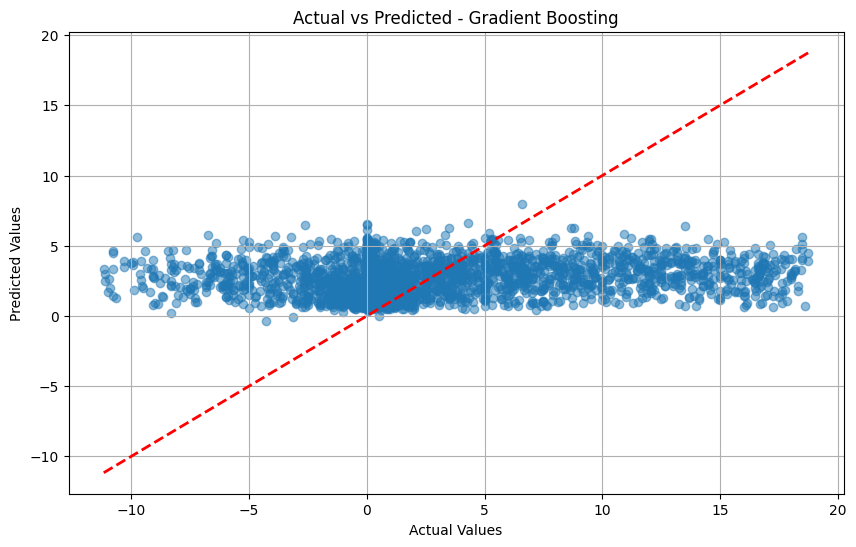

[9/11] Training and evaluating: Extra Trees... ✓ (GridSearch complete)

Best params:
   - max_depth: 5
   - min_samples_split: 10
   - n_estimators: 100


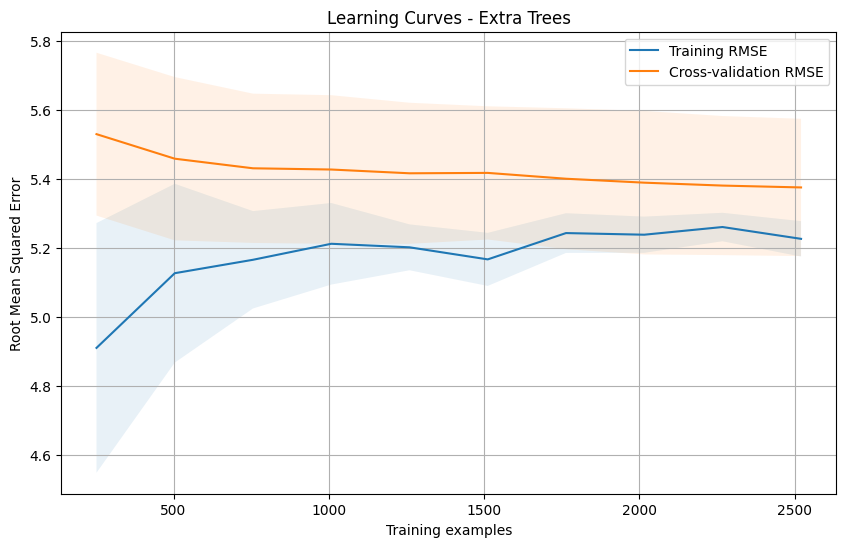

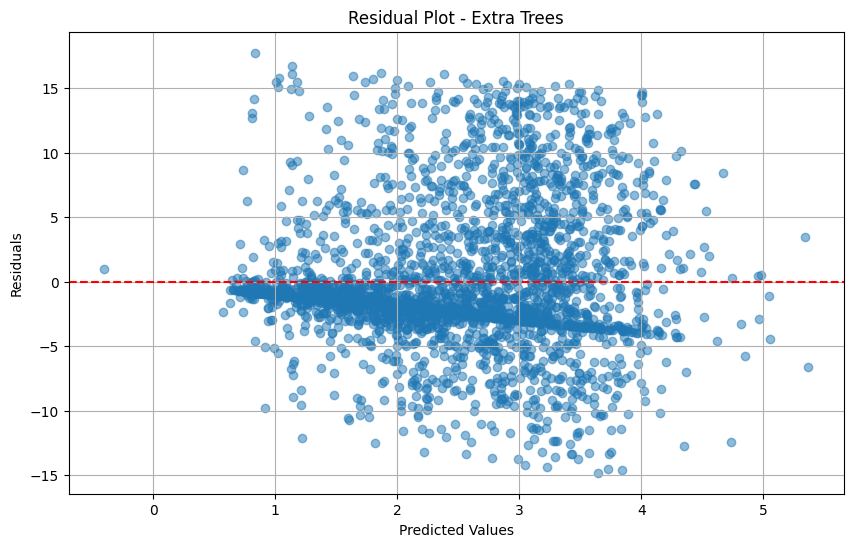

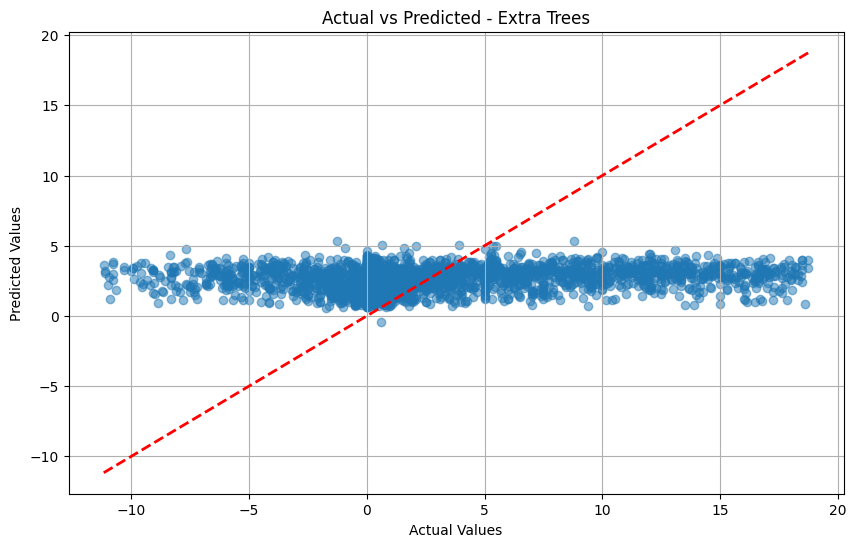

[10/11] Training and evaluating: Kernel Ridge... ✓ (GridSearch complete)

Best params:
   - alpha: 0.1
   - gamma: 0.001


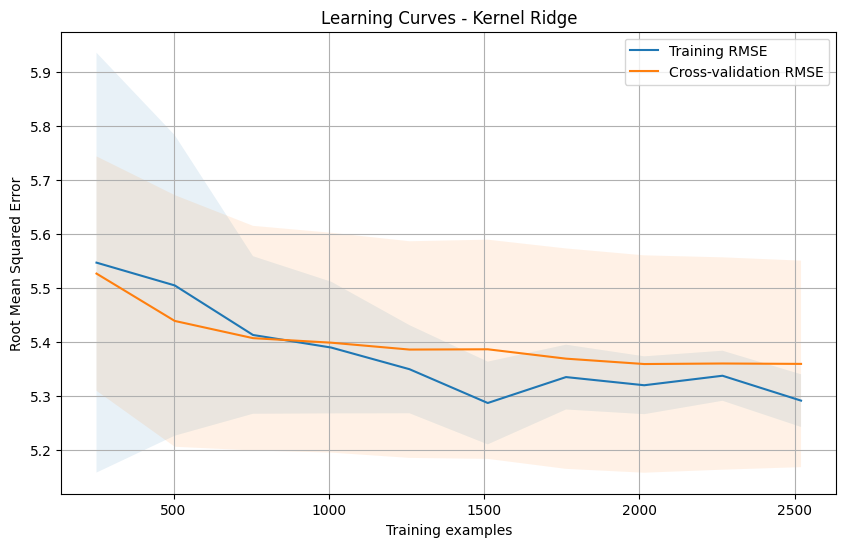

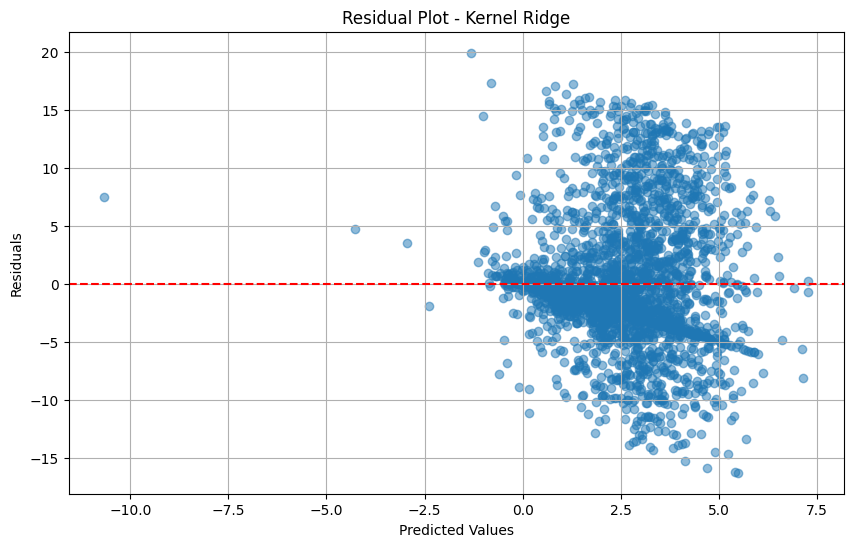

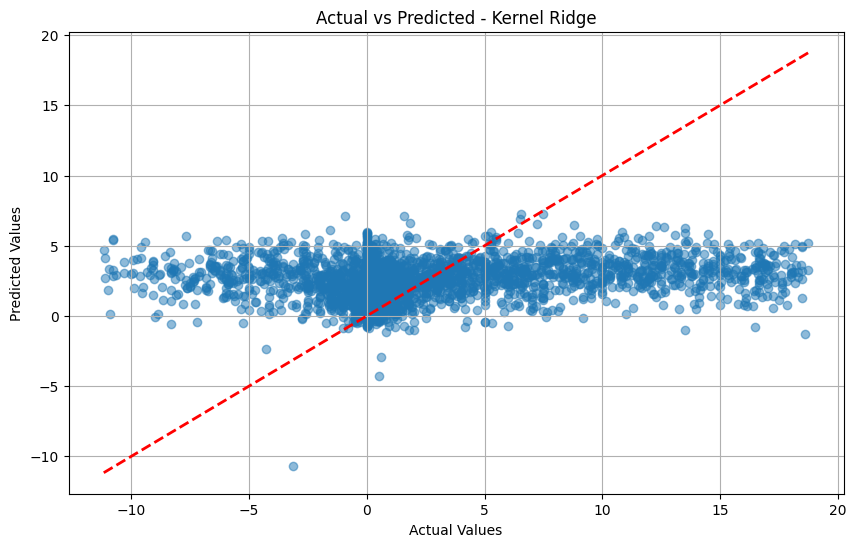

[11/11] Training and evaluating: Neural Network... ✓ (GridSearch complete)

Best params:
   - activation: relu
   - alpha: 0.01
   - hidden_layer_sizes: (100, 50)
   - learning_rate_init: 0.005


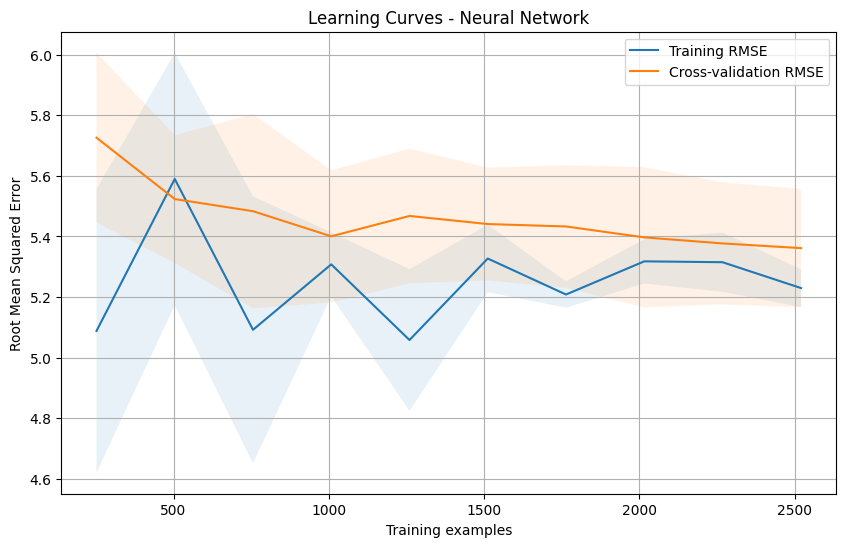

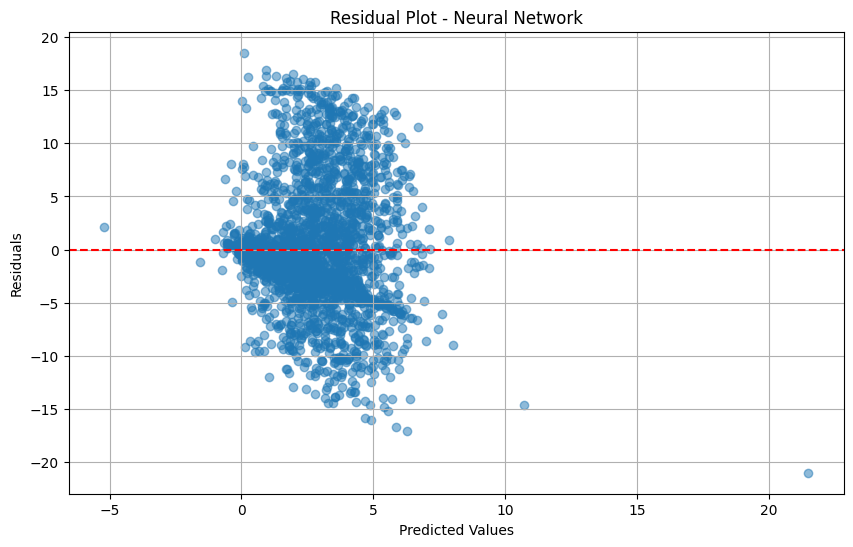

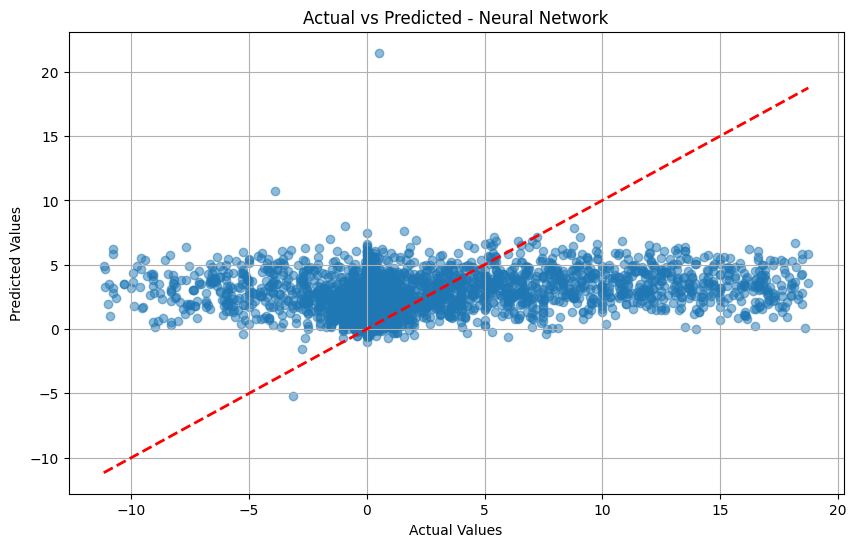


Top 5 Models:


,Model,R²,RMSE,MAE,MSE
0,LightGBM,0.058635,5.354790,3.825352,28.717326
1,Kernel Ridge,0.056828,5.359379,3.841042,28.759408
2,Neural Network,0.056794,5.359466,3.848842,28.759697
3,Random Forest (Light),0.056170,5.360961,3.801284,28.777944
4,Gradient Boosting,0.054479,5.365855,3.857138,28.829140


Best model: LightGBM
Best model params: 
   - boosting_type: gbdt
   - class_weight: None
   - colsample_bytree: 1.0
   - importance_type: split
   - learning_rate: 0.1
   - max_depth: -1
   - min_child_samples: 20
   - min_child_weight: 0.001
   - min_split_gain: 0.0
   - n_estimators: 100
   - n_jobs: None
   - num_leaves: 31
   - objective: None
   - random_state: 42
   - reg_alpha: 0.0
   - reg_lambda: 0.0
   - subsample: 1.0
   - subsample_for_bin: 200000
   - subsample_freq: 0
   - force_col_wise: True
   - min_data_in_leaf: 10
   - feature_fraction: 0.8
   - bagging_fraction: 0.8
   - bagging_freq: 1
   - verbose: -1

Best Model Test Set Performance:


,Model,RMSE,MAE,R² Score
0,LightGBM,6.06936,4.443608,-0.178402



Dummy Model Test Set Performance:


,Model,RMSE,MAE,R² Score
0,Dummy Regressor,5.593403,4.180957,-0.000829


In [ ]:
main()